# Brain Tumor Classification using Deep Learning
This project uses transfer learning with the VGG16 model to perform binary classification on brain MRI images. The dataset consists of labeled MRI scans categorized into "tumor" and "no tumor".

The workflow of this project involves several key steps:

1. Data Preprocessing: Loading MRI images, resizing them to 224x224 pixels, normalizing pixel values, and encoding labels into binary classes ("tumor" and "no tumor").
2. Data Augmentation: Using ImageDataGenerator to increase the diversity of the training set and reduce overfitting.
3. Model Building: Implementing transfer learning by using the pre-trained VGG16 model as a feature extractor and adding custom classification layers.
4. Model Training: Compiling and training the model using binary cross-entropy loss and accuracy as a performance metric.
5. Evaluation: Assessing model performance using confusion matrix, classification report, ROC curve, and Grad-CAM visualization.
6. Visualization: Plotting training accuracy/loss curves and visualizing sample predictions to interpret model behavior.

## Library Import

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2

## Load Dataset

In [2]:
path = r"C:\Users\Afifah Hadi Lestari\Downloads\My Projects\Brain Tumor Classification\brain_tumor_dataset"
print(os.listdir(path))

image_paths = list(paths.list_images(path))
print(len(image_paths))

['no', 'yes']
253


## Image Preprocessing

In [3]:
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    images.append(image)
    labels.append(label)

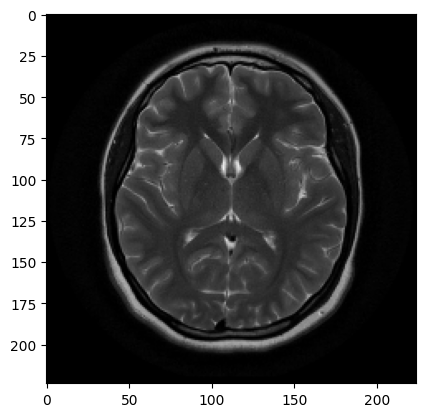

In [4]:
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])

In [5]:
images = np.array(images) / 255.0
labels = np.array(labels)

## Labels Encoding

In [6]:
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

print(labels[0])

[1. 0.]


## Split Dataset

In [7]:
(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)

## Data Augmentation

In [22]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  
)

In [9]:
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

## Load Pretrained Model (VGG16)

In [10]:
base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input
base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 512)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,747,650 (56.26 MB)

 Trainable params: 32,962 (128.76 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training Setup

In [14]:
batch_size = 8
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 10

## Model Training

In [15]:
import warnings
warnings.filterwarnings('ignore')
history = model.fit(train_generator.flow(train_X, train_Y, batch_size= batch_size),
                              steps_per_epoch= train_steps,
                              validation_data = (test_X, test_Y),
                              validation_steps= validation_steps,
                              epochs= epochs)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.6037 - loss: 0.7243 - val_accuracy: 0.6538 - val_loss: 0.6373
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.5000 - loss: 0.7675 - val_accuracy: 0.6538 - val_loss: 0.6348
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6305 - loss: 0.6733 - val_accuracy: 0.6538 - val_loss: 0.5695
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.2500 - loss: 0.8280 - val_accuracy: 0.6538 - val_loss: 0.5675
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6504 - loss: 0.6249 - val_accuracy: 0.8846 - val_loss: 0.5447
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.5000 - loss: 0.7416 - val_accuracy: 0.9231 - val_loss: 0.5462
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6367 - loss: 0.6235 - val_accuracy: 0.8846 - val_loss: 0.5325
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.7500 - loss: 0.6250 - val_accuracy: 0.9231 - v

## Save Trained Model

In [44]:
model.save("brain_tumor_classifier.keras")  

## Training Progress Visualization

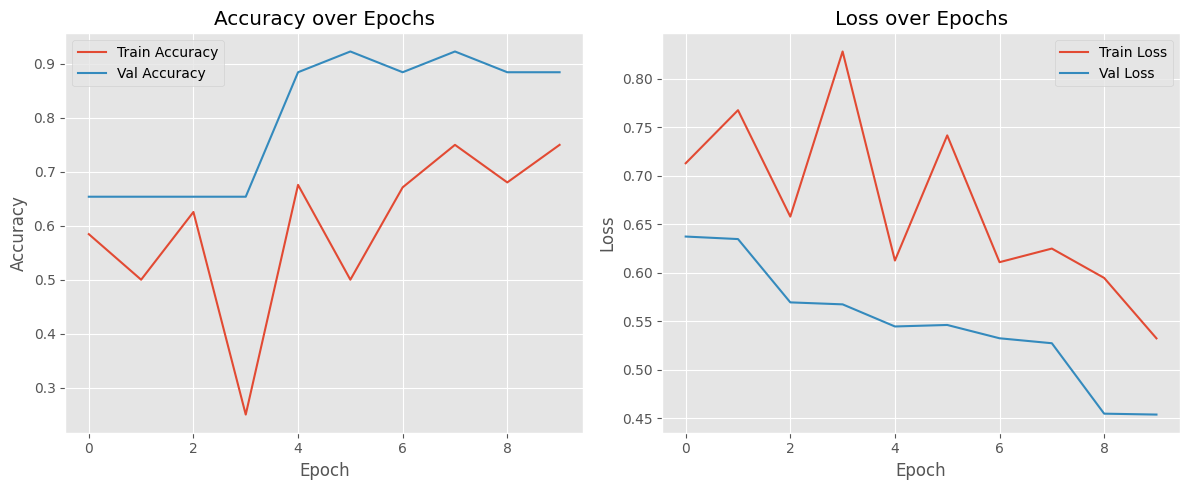

In [38]:
# Plot training accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


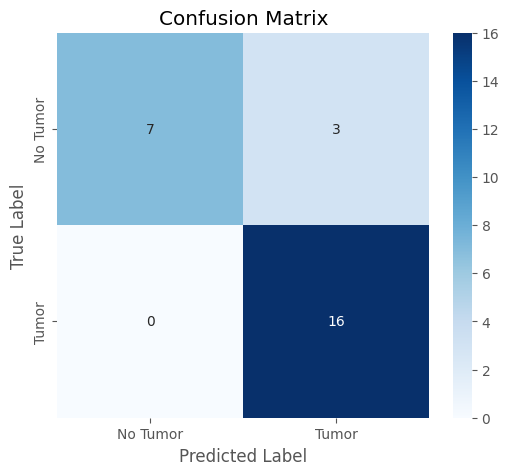

Classification Report:

              precision    recall  f1-score   support

    No Tumor       1.00      0.70      0.82        10
       Tumor       0.84      1.00      0.91        16

    accuracy                           0.88        26
   macro avg       0.92      0.85      0.87        26
weighted avg       0.90      0.88      0.88        26



In [48]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate predictions and actual labels
predictions = model.predict(test_X, batch_size=32)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_Y, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=["No Tumor", "Tumor"]))

In [16]:
predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


### ROC Curve & AUC (Area Under the Curve)

The ROC Curve (Receiver Operating Characteristic Curve) is a graphical representation used to evaluate the performance of a binary classification model, such as classifying brain MRI images into tumor and non-tumor categories.

- **X-axis (False Positive Rate)**: The rate at which the model incorrectly classifies non-tumor images as tumor.
- **Y-axis (True Positive Rate / Recall)**: The model’s ability to correctly identify tumor images.

The ROC Curve allows us to analyze the model's performance across different threshold values of prediction probabilities.

#### Interpreting the ROC Curve:
- A curve that is close to the **top-left corner** indicates a highly effective model.
- An **AUC score of 0.99** suggests that the model has an excellent ability to distinguish between tumor and non-tumor images.

#### Conclusion:
The brain tumor classification model demonstrates outstanding performance, as reflected by the near-perfect AUC score. This indicates the model’s strong reliability in detecting tumors from MRI scans.


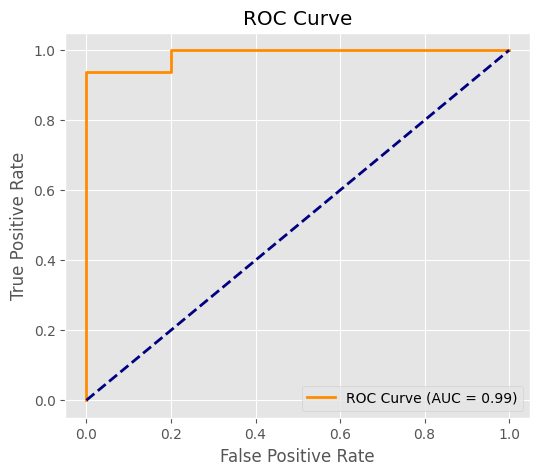

In [45]:
# ROC Curve & AUC Score
# Take the probability only for the “Tumor” class (index 1)
tumor_probabilities = predictions[:, 1]
fpr, tpr, _ = roc_curve(true_classes, tumor_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Final Model Accuracy

In [46]:
# Final accuracy
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.8846


## Example Prediction Result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


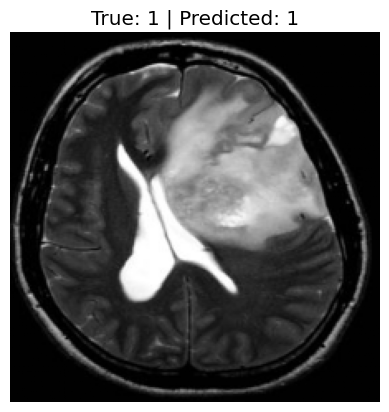

In [37]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Pick random sample to visualize
idx = random.randint(0, len(test_X) - 1)
sample_image = test_X[idx]
true_label = np.argmax(test_Y[idx])
pred_label = np.argmax(model.predict(sample_image[np.newaxis, ...]))

plt.imshow(sample_image)
plt.title(f"True: {true_label} | Predicted: {pred_label}")
plt.axis('off')
plt.show()


## Grad-CAM Visualization

In [20]:
import tensorflow as tf
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

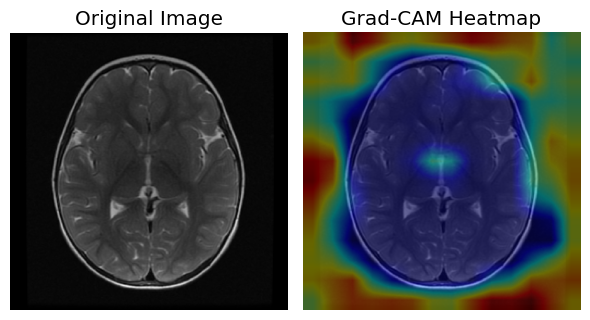

In [47]:
# Load 1 image from the datasett
sample_img_path = image_paths[10]  
orig = cv2.imread(sample_img_path)
image = cv2.resize(orig, (224, 224))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_array = np.expand_dims(image, axis=0) / 255.0

# Create heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block5_conv3")

# Superimpose heatmap to the original image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(orig, 0.6, heatmap, 0.4, 0)

# Plot
plt.figure(figsize=(6, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()